# Аналитика в Яндекс.Афише

**План действий:**

1. [Изучение и предобработка данных](#step1)
2. [Построение отчётов и подсчёт метрик](#step2)
    - 2.1 [Сколько людей пользуются в день, неделю, месяц?](#step21)
    - 2.2 [Сколько сессий в день?](#step22)
    - 2.3 [Сколько длится одна сессия?](#step23)
    - 2.4 [Как часто люди возвращаются?](#step24)
    - 2.5 [Когда люди начинают покупать?](#step25)
    - 2.6 [Сколько раз покупают за период?](#step26)
    - 2.7 [Какой средний чек?](#step27)
    - 2.8 [Сколько денег приносят? (LTV)](#step28)
    - 2.9 [Сколько денег потратили? Всего / на каждый источник / по времени](#step29)
    - 2.10 [Сколько стоило привлечение одного покупателя из каждого источника?](#step210)
    - 2.11 [На сколько окупились расходы? (ROMI)](#step211)
3. [Вывод и рекомендации](#step3)

## 1. Изучение и предобработка данных <a id="step1"></a>

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

visits_log = pd.read_csv('/datasets/visits_log.csv')
orders_log = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [5]:
def show_info(df):
    """Функция для отображения первых пяти строк датафрейма и информации о датафрейме"""
    display(df.head(5))
    display(df.info())  
    display(df.describe(include = [np.object])) 
    display(df.describe(include = [np.number])) 

In [6]:
visits_log.pipe(show_info)
visits_log.duplicated().sum()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

,Device,End Ts,Start Ts
count,359400,359400,359400
unique,2,224760,224303
top,desktop,2017-11-24 16:51:00,2017-11-24 16:06:00
freq,262567,23,19


,Source Id,Uid
count,359400.000,359400.000
mean,3.751,9202556994354921472.000
std,1.917,5298432824659611648.000
min,1.000,11863502262781.000
25%,3.000,4613406732167550976.000
50%,4.000,9227412908740601856.000
75%,5.000,13728237011236173824.000
max,10.000,18446676030785673216.000


0

In [7]:
orders_log.pipe(show_info)
orders_log.duplicated().sum()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.000,10329302124590727494
1,2017-06-01 00:25:00,0.550,11627257723692907447
2,2017-06-01 00:27:00,0.370,17903680561304213844
3,2017-06-01 00:29:00,0.550,16109239769442553005
4,2017-06-01 07:58:00,0.370,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

,Buy Ts
count,50415
unique,45991
top,2018-05-31 10:13:00
freq,9


,Revenue,Uid
count,50415.000,50415.000
mean,5.000,9098160634289729536.000
std,21.818,5285741550834715648.000
min,0.000,313578113262317.000
25%,1.220,4533566627250599936.000
50%,2.500,9102273602618561536.000
75%,4.890,13682901980465401856.000
max,2633.280,18446167067214817280.000


0

In [8]:
costs.pipe(show_info)
costs.duplicated().sum()

,source_id,dt,costs
0,1,2017-06-01,75.200
1,1,2017-06-02,62.250
2,1,2017-06-03,36.530
3,1,2017-06-04,55.000
4,1,2017-06-05,57.080


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

,dt
count,2542
unique,364
top,2018-02-12
freq,7


,source_id,costs
count,2542.000,2542.000
mean,4.857,129.477
std,3.182,156.297
min,1.000,0.540
25%,2.000,21.945
50%,4.000,77.295
75%,9.000,170.065
max,10.000,1788.280


0

In [9]:
# Создадим функцию для приведения названий столбцов к нижнему регистру
def str_lower(df):
    df.columns = df.columns.str.lower()
# Применим её для датасетов    
visits_log.pipe(str_lower)  
orders_log.pipe(str_lower)
# Переименуем названия столбцов с пробелами
visits_log = visits_log.rename(columns={'end ts':'end_ts',
                                       'start ts':'start_ts',
                                       'source id':'source_id'})
orders_log = orders_log.rename(columns={'buy ts':'buy_ts'})

In [10]:
# Заменим тип данных на формат для дат
visits_log = visits_log.assign(
    end_ts = lambda x: pd.to_datetime(x['end_ts'],format='%Y-%m-%d %H:%M:%S'),
    start_ts = lambda x: pd.to_datetime(x['start_ts'],format='%Y-%m-%d %H:%M:%S')
)
orders_log = orders_log.assign(
    buy_ts = lambda x: pd.to_datetime(x['buy_ts'],format='%Y-%m-%d %H:%M:%S')
)
costs = costs.assign(
    dt = lambda x: pd.to_datetime(x['dt'],format='%Y-%m-%d')
)

### Вывод 

Данные изучены и преобразованы для дальнейшей работы с ними. Названия столбцов были приведены к нижнему регистру, а также заменены пробелы. Даты приведены к формату для даты и времени.

## 2. Построение отчётов и подсчёт метрик <a id="step2"></a>

### 2.1 Сколько людей пользуются в день, неделю, месяц? <a id="step21"></a>

In [11]:
# Создадидм столбцы для года, месяца, недели и даты посещения ресурса
visits_log['session_year']  = visits_log['start_ts'].dt.year
visits_log['session_month'] = visits_log['start_ts'].dt.month
visits_log['session_week']  = visits_log['start_ts'].dt.week
visits_log['session_date'] = visits_log['start_ts'].dt.date

# Рассчитаем значения DAU,MAU,WAU 
dau_total = visits_log.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = visits_log.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_total = visits_log.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
sticky_factor = float(dau_total*100/mau_total)
print('Показатели пользовательской оценки')
print('DAU:',int(dau_total))
print('WAU:',int(wau_total))
print('MAU:',int(mau_total))
print('Sticky factor: {:.2f}'.format(sticky_factor))
print('')


def dau_mau_wau(df):
    for device in ['desktop', 'touch']:
        df_final = df.query('device == @device')
        # Рассчитаем значения DAU,MAU,WAU 
        dau_total = df_final.groupby('session_date').agg({'uid': 'nunique'}).mean()
        wau_total = df_final.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
        mau_total = df_final.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
        sticky_factor = float(dau_total*100/mau_total)

        print('Показатели пользовательской оценки {:}'.format(device))

        print('DAU:',int(dau_total))
        print('WAU:',int(wau_total))
        print('MAU:',int(mau_total))
        print('Sticky factor: {:.2f}'.format(sticky_factor))
        print('')
dau_mau_wau(visits_log)        

Показатели пользовательской оценки
DAU: 907
WAU: 5716
MAU: 23228
Sticky factor: 3.91

Показатели пользовательской оценки desktop
DAU: 659
WAU: 4129
MAU: 16724
Sticky factor: 3.94

Показатели пользовательской оценки touch
DAU: 252
WAU: 1634
MAU: 6825
Sticky factor: 3.70



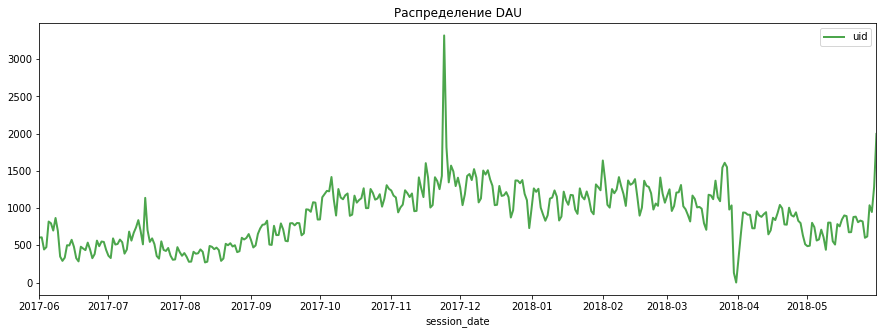

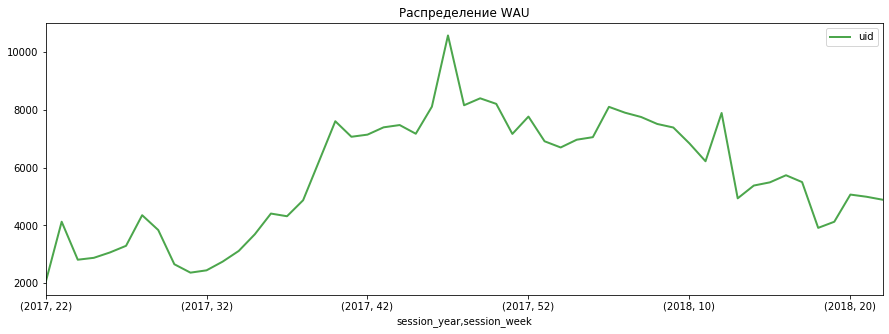

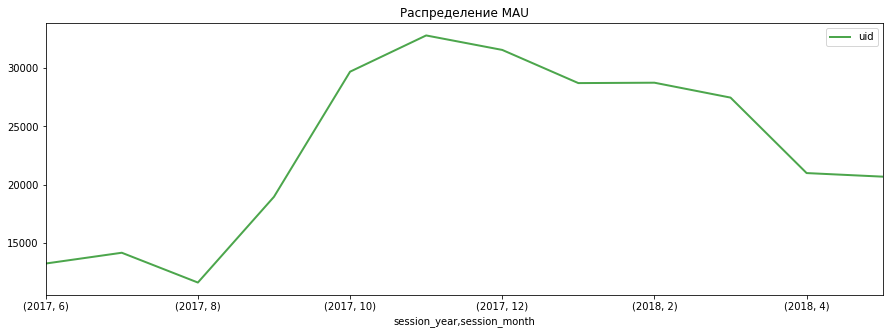

In [12]:
# Рассчитаем значения DAU,MAU,WAU 
visits_log.groupby('session_date').\
           agg({'uid': 'nunique'}).\
           plot(color='g', 
                alpha=0.7, 
                linewidth=2, 
                figsize=(15,5), 
                title='Распределение DAU')
visits_log.groupby(['session_year', 'session_week']).\
           agg({'uid': 'nunique'}).\
           plot(color='g', 
                alpha=0.7, 
                linewidth=2, 
                figsize=(15,5),
                title='Распределение WAU')
visits_log.groupby(['session_year', 'session_month']).\
           agg({'uid': 'nunique'}).\
           plot(color='g', 
                alpha=0.7, 
                linewidth=2, 
                figsize=(15,5),
                title='Распределение MAU')

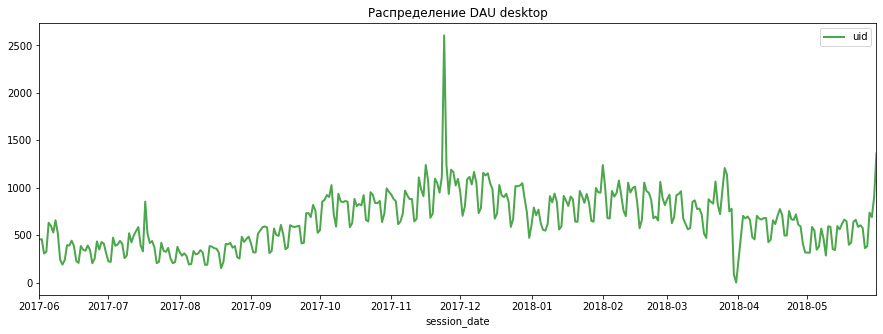

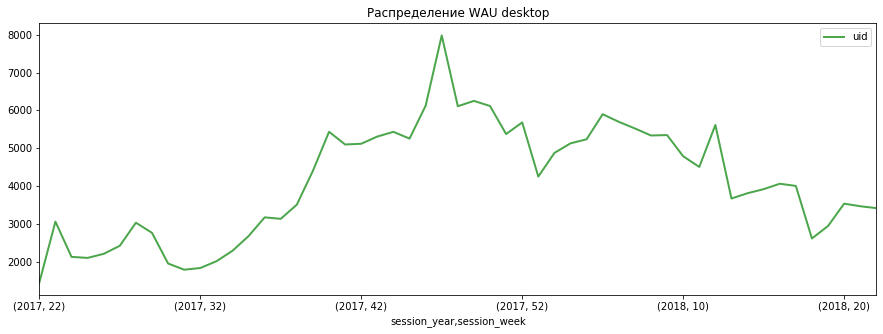

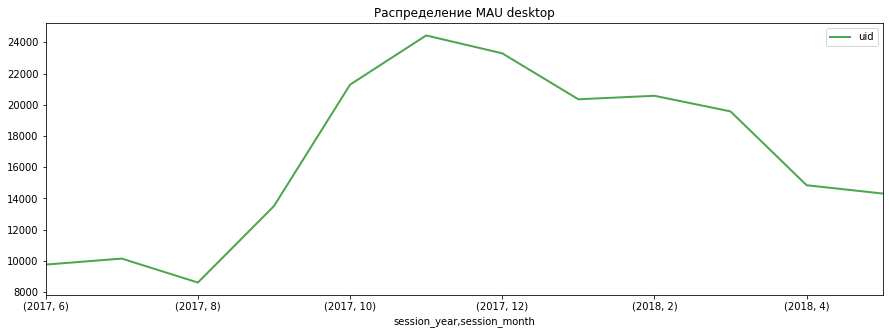

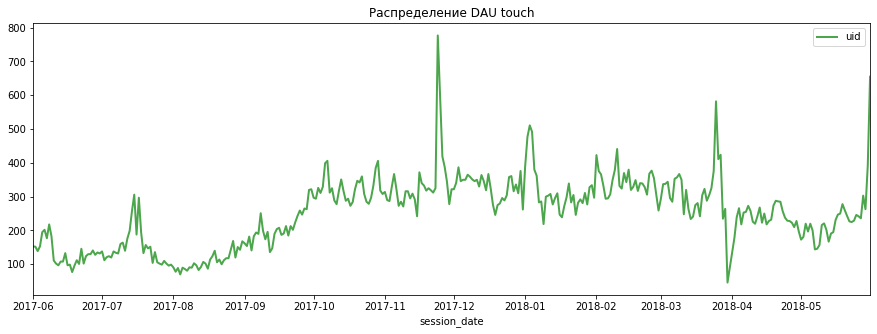

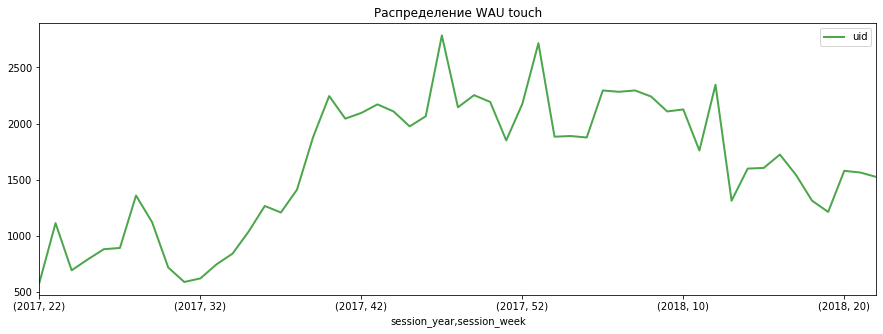

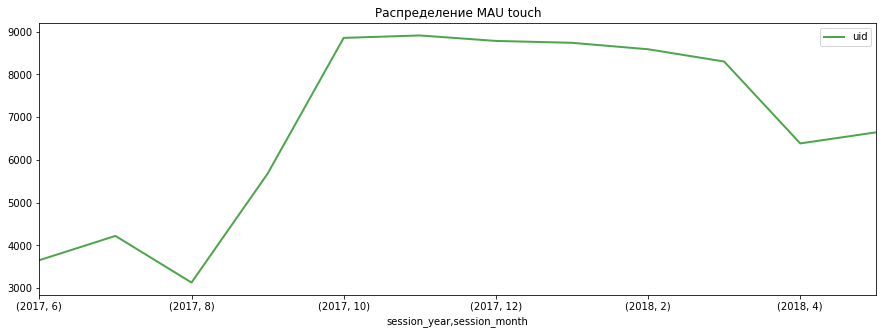

In [13]:
def dau_mau_wau(df):
    for device in ['desktop', 'touch']:
        df_final = df.query('device == @device')

        # Рассчитаем значения DAU,MAU,WAU 
        
        df_final.groupby('session_date').\
                   agg({'uid': 'nunique'}).\
                   plot(color='g', 
                        alpha=0.7, 
                        linewidth=2, 
                        figsize=(15,5), 
                        title='Распределение DAU {:}'.format(device))
        
        df_final.groupby(['session_year', 'session_week']).\
                   agg({'uid': 'nunique'}).\
                   plot(color='g', 
                        alpha=0.7, 
                        linewidth=2, 
                        figsize=(15,5),
                        title='Распределение WAU {:}'.format(device))
        
        df_final.groupby(['session_year', 'session_month']).\
                   agg({'uid': 'nunique'}).\
                   plot(color='g', 
                        alpha=0.7, 
                        linewidth=2, 
                        figsize=(15,5),
                        title='Распределение MAU {:}'.format(device))
dau_mau_wau(visits_log)        

### Вывод

Проанализировали показатели дневной, недельной и суточной посещаемости сервиса. Видим, что большая часть пользователей из десктоп версии(порядка 70%). По распределию есть ряд пиковых значений, которые соотноситься с маркетинговым продвижением или акциями, тогда как нижние пики могут свидетельствовать о падении сайта. Графики распределения пользователей для обоих девайсов довольно идентичные. 

### 2.2 Сколько сессий в день? <a id="step22"></a>

Среднее количество сессий на пользователя: 1.08


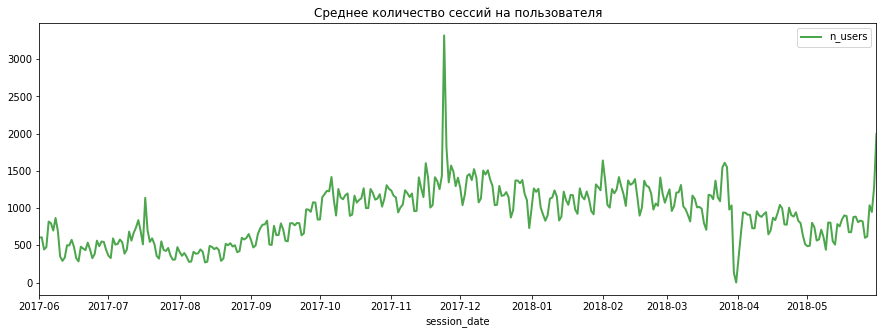

In [14]:
sessions_per_user = visits_log.groupby(['session_year', 'session_month','session_date']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user.groupby('session_date').\
                  agg({'n_users': 'sum'}).\
                  plot(color='g', 
                       alpha=0.7, 
                       linewidth=2, 
                       figsize=(15,5),
                       title='Среднее количество сессий на пользователя')
print('Среднее количество сессий на пользователя: {:.2f}'.format(sessions_per_user['sessions_per_user'].mean()))

desktop
Среднее количество сессий на пользователя: 1.09

touch
Среднее количество сессий на пользователя: 1.05



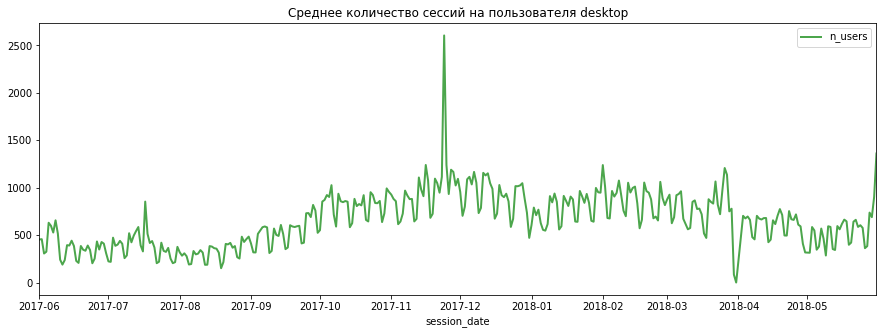

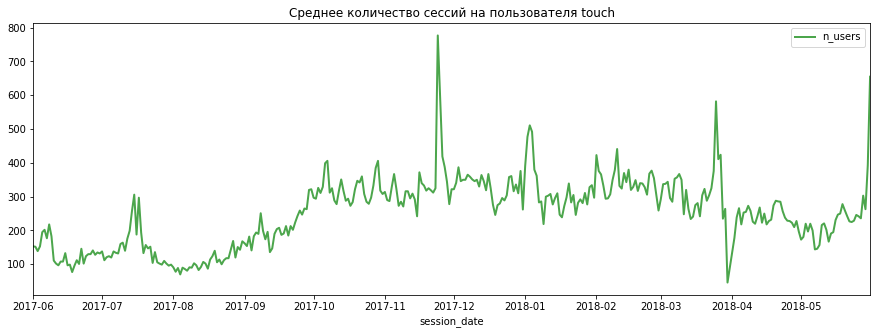

In [15]:
sessions_per_user = visits_log.groupby(['session_year', 'session_month','session_date','device']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']

def sess_count(df):
    for device in ['desktop', 'touch']:
        df_final = df.query('device == @device')

        df_final.groupby('session_date').\
                          agg({'n_users': 'sum'}).\
                          plot(color='g', 
                               alpha=0.7, 
                               linewidth=2, 
                               figsize=(15,5),
                               title='Среднее количество сессий на пользователя {:}'.format(device))
        print('{:}'.format(device))
        print('Среднее количество сессий на пользователя: {:.2f}'.format(df_final['sessions_per_user'].mean()))
        print('')
sess_count(sessions_per_user)

### Вывод

Вычислили среднее количество сессий на юзера –– 1.08. То есть в большинстве случаев пользователи посещают сервис 1 раз и возращаются довольно редко. Данные для девайсов слабо различаются.

### 2.3 Сколько длится одна сессия? <a id="step23"></a>

In [16]:
visits_log['session_duration_sec'] = (visits_log['end_ts'] - visits_log['start_ts']).dt.seconds
print('Средняя продолжительность сессий: {:.2f}'.format(float(visits_log['session_duration_sec'].mean())))
print('')
print('Мода продолжительности сессий: {:.2f}'.format(float(visits_log['session_duration_sec'].mode())))
print('')
print('Медиана продолжительности сессий: {:.2f}'.format(float(visits_log['session_duration_sec'].median())))

Средняя продолжительность сессий: 643.51

Мода продолжительности сессий: 60.00

Медиана продолжительности сессий: 300.00


desktop
Средняя продолжительность сессий: 703.95
Мода продолжительности сессий: 60.00
Медиана продолжительности сессий: 360.00

touch
Средняя продолжительность сессий: 479.62
Мода продолжительности сессий: 60.00
Медиана продолжительности сессий: 180.00



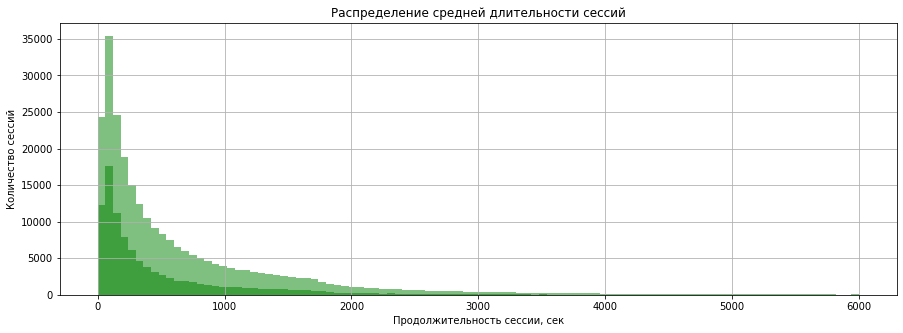

In [17]:
def sess_duration(df):
    for device in ['desktop', 'touch']:
        df_final = df.query('device == @device')
        print('{:}'.format(device))
        print('Средняя продолжительность сессий: {:.2f}'.format(float(df_final['session_duration_sec'].mean())))
        
        print('Мода продолжительности сессий: {:.2f}'.format(float(df_final['session_duration_sec'].mode())))
        
        print('Медиана продолжительности сессий: {:.2f}'.format(float(df_final['session_duration_sec'].median())))
        print('')
        df_final['session_duration_sec'].hist(bins=100,range=(0,6000),color='g', 
                       alpha=0.5, 
                       linewidth=2, 
                       figsize=(15,5))
        plt.title('Распределение средней длительности сессий')
        plt.xlabel('Продолжительность сессии, сек')
        plt.ylabel('Количество сессий')
sess_duration(visits_log)        

Text(0, 0.5, 'Количество сессий')

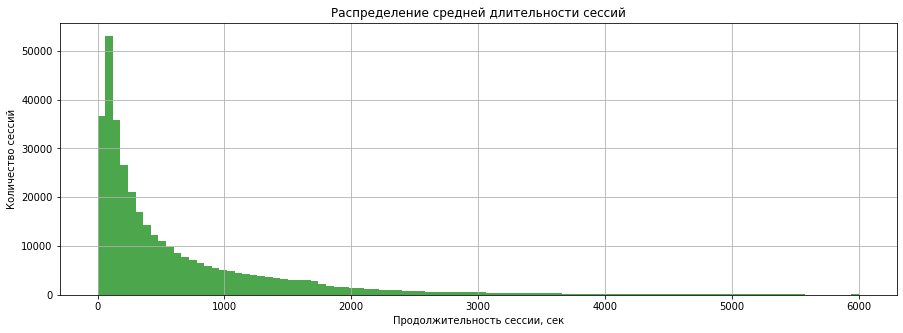

In [18]:
visits_log['session_duration_sec'].hist(bins=100,range=(0,6000),color='g', 
                       alpha=0.7, 
                       linewidth=2, 
                       figsize=(15,5))
plt.title('Распределение средней длительности сессий')
plt.xlabel('Продолжительность сессии, сек')
plt.ylabel('Количество сессий')

### Вывод

В качестве средней продолжительности сессии будем учитывать моду как наиболее частую ситуацию для пользователей. Мода по девайсам не различается, однако средняя продолжительность и медиана для десктопа выше, что объясняется разным поведением использования данных устройств. Продолжительность сессий представлена распределением Пуассона. 

### 2.4 Как часто люди возвращаются? <a id="step24"></a>

In [19]:
first_activity_date = visits_log.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits_log = visits_log.join(first_activity_date,on='uid')

In [20]:
visits_log['activity_month'] = visits_log['start_ts'].astype('datetime64[M]')
visits_log['first_activity_month'] = visits_log['first_activity_date'].astype('datetime64[M]')

In [21]:
visits_log['cohort_lifetime'] = visits_log['activity_month'] - visits_log['first_activity_month']
visits_log['cohort_lifetime'] = visits_log['cohort_lifetime'] / np.timedelta64(1,'M')
visits_log['cohort_lifetime'] = visits_log['cohort_lifetime'].round().astype('int')
visits_log['cohort_lifetime']
display(visits_log[['first_activity_month','activity_month','cohort_lifetime']].head())


,first_activity_month,activity_month,cohort_lifetime
0,2017-12-01,2017-12-01,0
1,2018-02-01,2018-02-01,0
2,2017-07-01,2017-07-01,0
3,2018-03-01,2018-05-01,2
4,2017-12-01,2017-12-01,0


Retention rate на второй месяц жизни когорты(1 период) 
0.72

Retention rate на второй месяц жизни когорты(1 период) desktop
0.75

Retention rate на второй месяц жизни когорты(1 период) touch
0.68



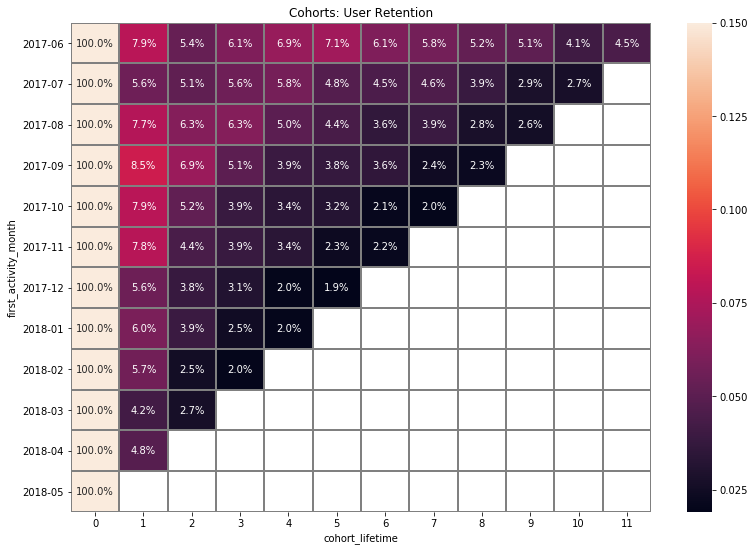

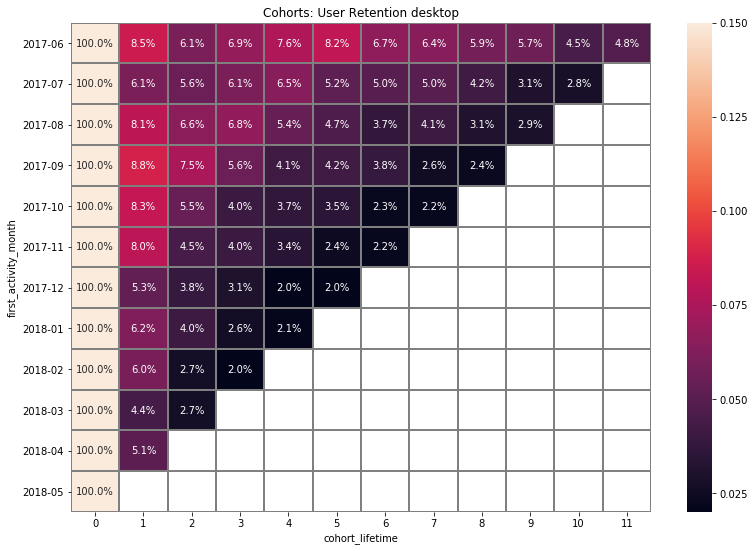

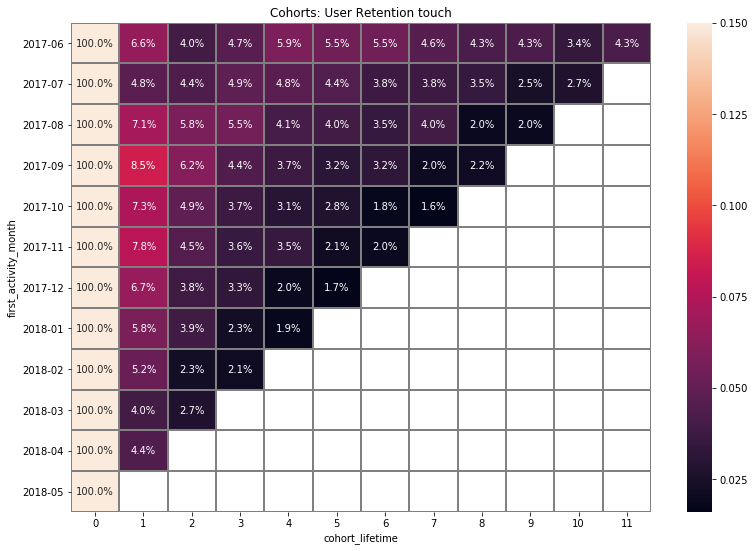

In [22]:
cohorts = visits_log.groupby(['first_activity_month','cohort_lifetime']).\
                    agg({'uid':'nunique'}).\
                    reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts = cohorts.reset_index()
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime('%Y-%m')
retention_pivot = cohorts.pivot_table(index='first_activity_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray',vmax=0.15);
print('Retention rate на второй месяц жизни когорты(1 период) ')
print('{:.2f}'.format(cohorts[cohorts['cohort_lifetime']==1]['retention'].sum()))
print('')


def retention_rate(df):
    for device in ['desktop', 'touch']:
        df_final = df.query('device == @device')
        cohorts = df_final.groupby(['first_activity_month','cohort_lifetime']).\
                    agg({'uid':'nunique'}).\
                    reset_index()
        initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
        initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
        cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
        cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
        cohorts = cohorts.reset_index()
        cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime('%Y-%m')
        retention_pivot = cohorts.pivot_table(index='first_activity_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')
        plt.figure(figsize=(13, 9))
        plt.title('Cohorts: User Retention {:}'.format(device))
        sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray',vmax=0.15);
        print('Retention rate на второй месяц жизни когорты(1 период) {:}'.format(device))
        print('{:.2f}'.format(cohorts[cohorts['cohort_lifetime']==1]['retention'].sum()))
        print('')


retention_rate(visits_log)

### Вывод

Изучив получившиеся графики можем заключить, что пользователи возвращаются довольно слабо. В целом это может быть связано с особенностью ресурса. Билеты на мероприятия или в кино могут покупать нерегулярно, это нормально. Первая когорта даёт аномальные значения, поскольку на 5-ый месяц жизни там наблюдается даже небольшой прирост пользователей. В остальных когортах идёт постепенное убывание пользователей. Для тач устройств оно происходит быстрее, а сам retention rate когорт для них ниже, чем для десктопа.

### 2.5 Когда люди начинают покупать? <a id="step25"></a>

Среднее время до начала покупки, сек: 1460410.55
Мода среднего времени до начала покупки, сек: 60.00
Медиана среднего времени до начала покупки, сек: 960.00



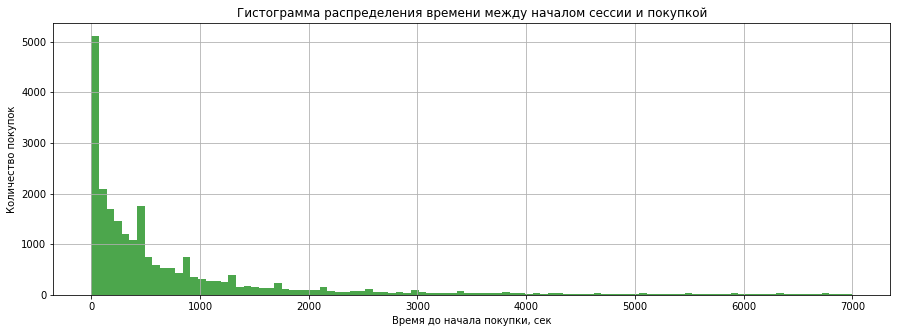

In [23]:
visits_log_new = visits_log.groupby(['uid'])['source_id', 'device'].first() 
orders_log = orders_log.merge(visits_log_new,on='uid')

orders_log_groupped = orders_log.groupby('uid')['buy_ts'].min()
visits_log_groupped = visits_log.groupby('uid')['start_ts'].min()

visits_log_groupped = pd.merge(visits_log_groupped,orders_log_groupped,on='uid')
visits_log_groupped['period_to_buy'] = visits_log_groupped['buy_ts'] - visits_log_groupped['start_ts']
visits_log_groupped['period_to_buy'] = (visits_log_groupped['period_to_buy'] / np.timedelta64(1, 's')).astype(int) 
visits_log_groupped['period_to_buy'].hist(bins=100,range=(0,7000),color='g', 
                       alpha=0.7, 
                       linewidth=2, 
                       figsize=(15,5))
plt.title('Гистограмма распределения времени между началом сессии и покупкой')
plt.xlabel('Время до начала покупки, сек')
plt.ylabel('Количество покупок')

print('Среднее время до начала покупки, сек: {:.2f}'.format(float(visits_log_groupped['period_to_buy'].mean())))       
print('Мода среднего времени до начала покупки, сек: {:.2f}'.format(float(visits_log_groupped['period_to_buy'].mode())))
print('Медиана среднего времени до начала покупки, сек: {:.2f}'.format(float(visits_log_groupped['period_to_buy'].median())))
print('')

desktop
60     2154
0      1928
120    1692
180    1393
240    1192
300    1012
360     907
420     810
480     664
540     638
Name: period_to_buy, dtype: int64

Среднее время до начала покупки, сек: 1411771.24
Мода среднего времени до начала покупки, сек: 60.00
Медиана среднего времени до начала покупки, сек: 900.00

touch
0      527
60     502
120    406
180    292
240    268
300    192
360    170
420    160
480    129
600    106
Name: period_to_buy, dtype: int64

Среднее время до начала покупки, сек: 1655087.71
Мода среднего времени до начала покупки, сек: 0.00
Медиана среднего времени до начала покупки, сек: 1620.00



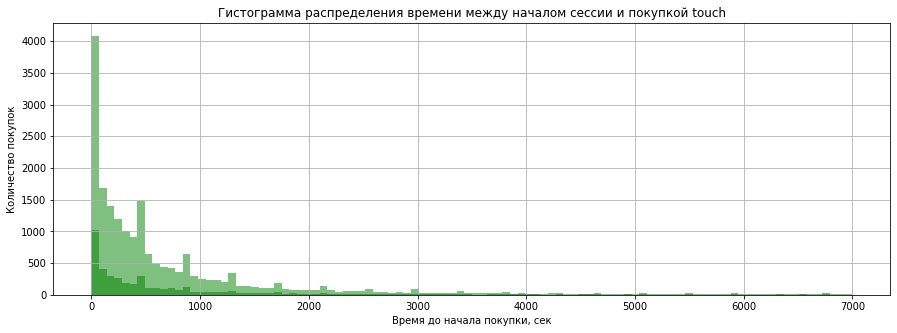

In [24]:
def time_to_buy(df):
    for device in ['desktop', 'touch']:
        df_final = df.query('device == @device')
        orders_log_groupped = df_final.groupby('uid')['buy_ts'].min()
        visits_log_groupped = visits_log.groupby('uid')['start_ts'].min()

        visits_log_groupped = pd.merge(visits_log_groupped,orders_log_groupped,on='uid')
        visits_log_groupped['period_to_buy'] = visits_log_groupped['buy_ts'] - visits_log_groupped['start_ts']
        visits_log_groupped['period_to_buy'] = (visits_log_groupped['period_to_buy'] / np.timedelta64(1, 's')).astype(int) 
        visits_log_groupped['period_to_buy'].hist(bins=100,range=(0,7000),color='g', 
                               alpha=0.5, 
                               linewidth=2, 
                               figsize=(15,5))
        plt.title('Гистограмма распределения времени между началом сессии и покупкой {:}'.format(device))
        plt.xlabel('Время до начала покупки, сек')
        plt.ylabel('Количество покупок')
        print('{:}'.format(device))
        print(visits_log_groupped['period_to_buy'].value_counts().head(10))
        print('')
        print('Среднее время до начала покупки, сек: {:.2f}'.format(float(visits_log_groupped['period_to_buy'].mean())))       
        print('Мода среднего времени до начала покупки, сек: {:.2f}'.format(float(visits_log_groupped['period_to_buy'].mode())))
        print('Медиана среднего времени до начала покупки, сек: {:.2f}'.format(float(visits_log_groupped['period_to_buy'].median())))
        print('')
        
time_to_buy(orders_log)

Text(0, 0.5, 'Количество сессий перед покупкой')

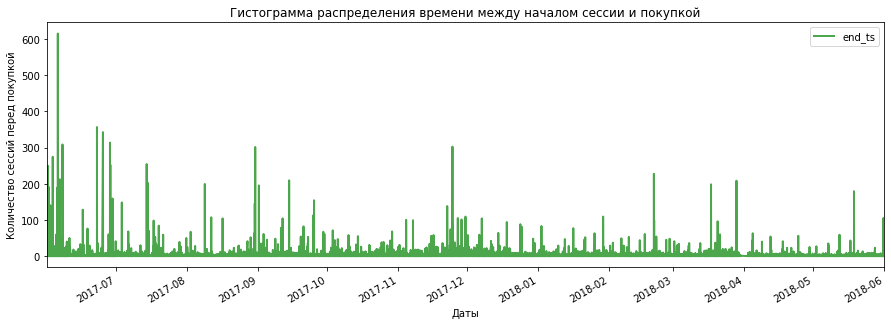

In [25]:
visits_log_groupped_final = visits_log.groupby('uid').\
                                        agg({'start_ts':'min',
                                            'end_ts':'count'})
visits_log_groupped_final = pd.merge(visits_log_groupped_final,orders_log_groupped,on='uid')
visits_log_groupped_final.plot(x='buy_ts',
                               y='end_ts',
                              color='g', 
                              alpha=0.7, 
                              linewidth=2, 
                              figsize=(15,5))
plt.title('Гистограмма распределения времени между началом сессии и покупкой')
plt.xlabel('Даты')
plt.ylabel('Количество сессий перед покупкой')


In [26]:
visits_log_groupped_final['end_ts'].describe()

count   36523.000
mean        2.667
std         8.468
min         1.000
25%         1.000
50%         1.000
75%         3.000
max       615.000
Name: end_ts, dtype: float64

### Вывод

В среднем пользователи начинают делать покупки спустя 16 минут на сайте(по медианным значениям), однако, существует ряд пользователей для которых время для покупки равно 0. Возможно они перешли по прямой ссылке на покупку и купили довольно быстро и сразу. Я бы уточнила у коллег о возможных причинах таких данных в базах. Может быть по части покупок или сессий было указано не самое точное время. 

### 2.6 Сколько раз покупают за период? <a id="step26"></a>

In [27]:
first_order_date = orders_log.groupby('uid')['buy_ts'].min() 
first_order_date.name = 'first_order_date'
orders_log = orders_log.join(first_order_date,on='uid')
orders_log_new = orders_log
orders_log_new['first_order_month'] =  orders_log_new['first_order_date'].astype('datetime64[M]')
orders_log_new['order_month'] = orders_log_new['buy_ts'].astype('datetime64[M]')
orders_log_new['first_order_month'] = orders_log_new['first_order_month'].dt.strftime('%Y-%m')
orders_log_new['order_month'] = orders_log_new['order_month'].dt.strftime('%Y-%m')

In [28]:
orders_log_new.head(5)

,buy_ts,revenue,uid,source_id,device,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.000,10329302124590727494,1,desktop,2017-06-01 00:10:00,2017-06,2017-06
1,2017-06-01 00:25:00,0.550,11627257723692907447,2,desktop,2017-06-01 00:25:00,2017-06,2017-06
2,2017-06-01 00:27:00,0.370,17903680561304213844,2,desktop,2017-06-01 00:27:00,2017-06,2017-06
3,2017-06-01 00:29:00,0.550,16109239769442553005,2,desktop,2017-06-01 00:29:00,2017-06,2017-06
4,2017-06-01 07:58:00,0.370,14200605875248379450,3,desktop,2017-06-01 07:58:00,2017-06,2017-06


In [29]:
orders_log_new_final = orders_log_new.groupby(['uid','first_order_month','order_month','device']).\
                                      agg({
                                        'buy_ts':'count'})
orders_log_new_final.head(5)

,,,,buy_ts
uid,first_order_month,order_month,device,
313578113262317,2018-01,2018-01,desktop,1
1575281904278712,2017-06,2017-06,touch,2
2429014661409475,2017-10,2017-10,desktop,1
2464366381792757,2018-01,2018-01,desktop,1
2551852515556206,2017-11,2017-11,desktop,2


desktop
Среднее количество покупок на пользователя за 6 месяцев: 7.19

touch
Среднее количество покупок на пользователя за 6 месяцев: 4.51



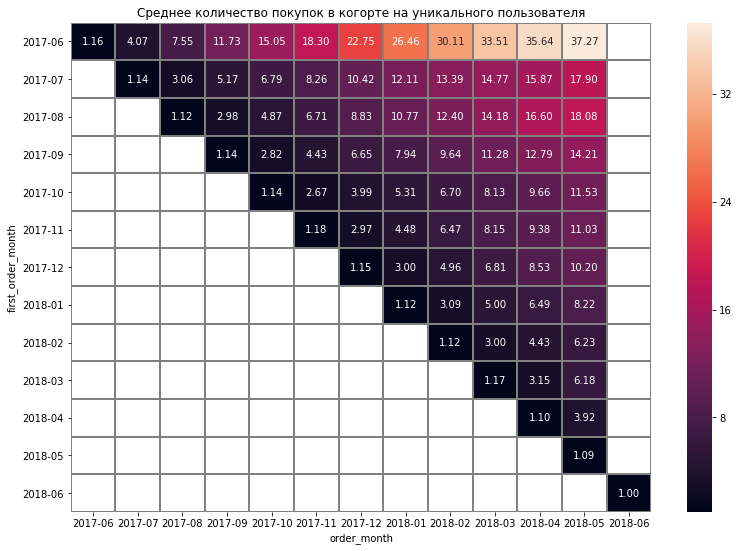

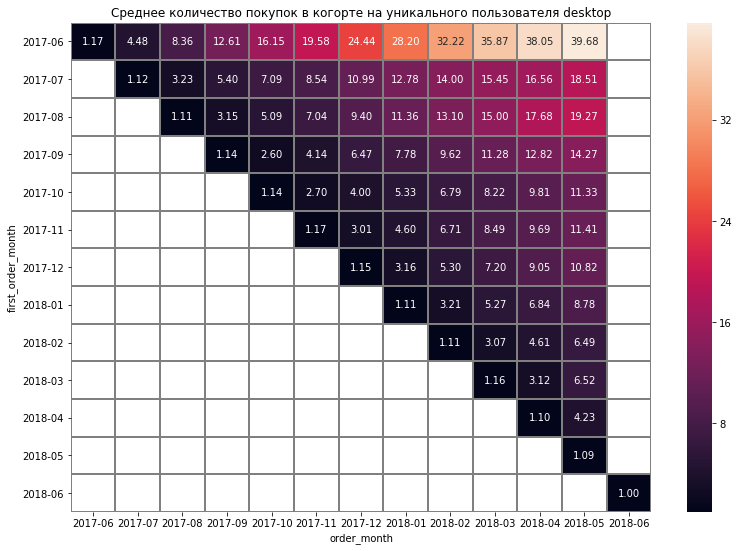

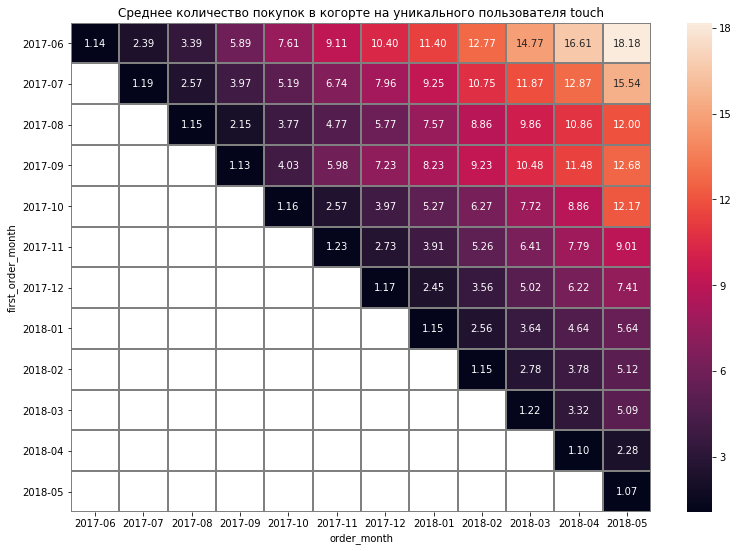

In [30]:
orders_log_new_final_pivot = orders_log_new_final.pivot_table(index='first_order_month',
                                columns='order_month',
                                values='buy_ts',
                                aggfunc='mean').\
                                cumsum(axis=1)
plt.figure(figsize=(13, 9))
plt.title('Среднее количество покупок в когорте на уникального пользователя')

sns.heatmap(orders_log_new_final_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')


def mean_orders(df):
    for device in ['desktop', 'touch']:
        df_final = df.query('device == @device')
        df_final_pivot = df_final.pivot_table(index='first_order_month',
                                columns='order_month',
                                values='buy_ts',
                                aggfunc='mean').\
                                cumsum(axis=1)
        plt.figure(figsize=(13, 9))
        plt.title('Среднее количество покупок в когорте на уникального пользователя {:}'.format(device))
        sns.heatmap(df_final_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')  
        new = df_final.query('first_order_month <= "2017-12" & "2017-12" <= order_month < "2018-06"').pivot_table(index='first_order_month',
                                columns='order_month',
                                values='buy_ts',
                                aggfunc='mean').\
                                cumsum(axis=1)
        print('{:}'.format(device))
        print('Среднее количество покупок на пользователя за 6 месяцев: {:.2f}'.format(new.mean().sum()/6))
        print('')
mean_orders(orders_log_new_final)

In [31]:
new = orders_log_new_final.query('first_order_month <= "2017-12" & "2017-12" <= order_month < "2018-06"').pivot_table(index='first_order_month',
                                columns='order_month',
                                values='buy_ts',
                                aggfunc='mean').\
                                cumsum(axis=1)
print('Среднее количество покупок на пользователя за 6 месяцев: {:.2f}'.format(new.mean().sum()/6))

Среднее количество покупок на пользователя за 6 месяцев: 6.83


### Вывод

В среднем за период в 6 месяцев совершают 6.83 покупки. Для десктопа это большее количество. С тач устройства может быть не так удобно совершать покупку, поэтому для них среднее количество покупок меньше. Также отчётливо видно, что для первой когорты данные отличаются от остальных.  

### 2.7 Какой средний чек? <a id="step27"></a>

Средний чек с пользователя: 6.14


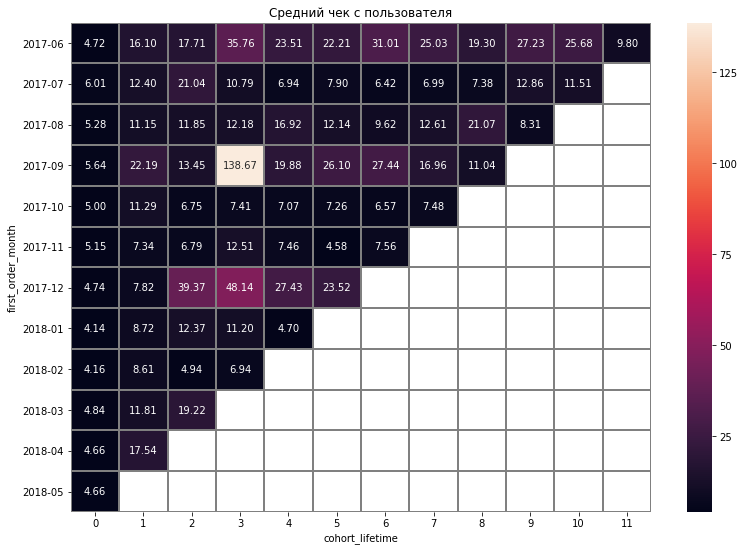

In [32]:
orders_grouped_by_cohorts = orders_log.groupby(['first_order_month','order_month']).\
                                        agg({'revenue':'sum','uid':'nunique'})
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']

orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['order_month'] = orders_grouped_by_cohorts['order_month'].astype('datetime64[M]')
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].astype('datetime64[M]')

orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')
orders_grouped_by_cohorts = orders_grouped_by_cohorts.query('first_order_month < "2018-06"')
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',
                                                               columns='cohort_lifetime',
                                                               values='revenue_per_user',
                                                               aggfunc='mean')
plt.figure(figsize=(13, 9))
plt.title('Средний чек с пользователя')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
revenue_per_user = orders_grouped_by_cohorts['revenue'].sum()/orders_grouped_by_cohorts['uid'].sum()
print('Средний чек с пользователя: {:.2f}'.format(revenue_per_user))


desktop
Средний чек с пользователя: 6.41

touch
Средний чек с пользователя: 5.04



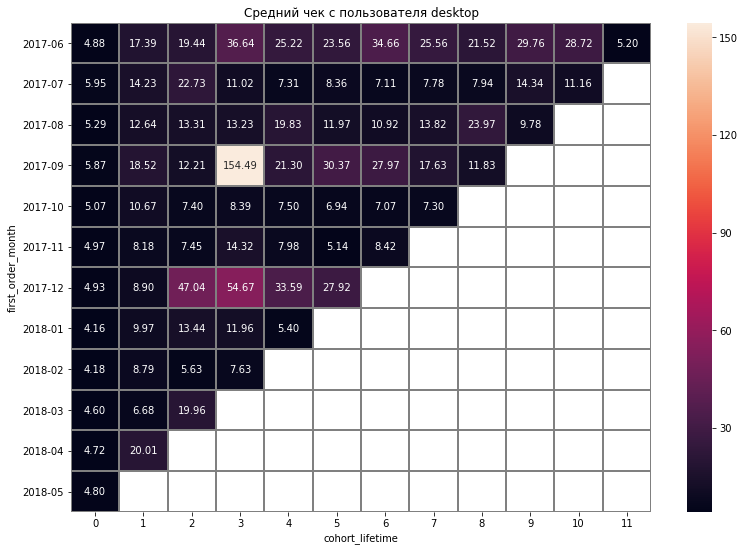

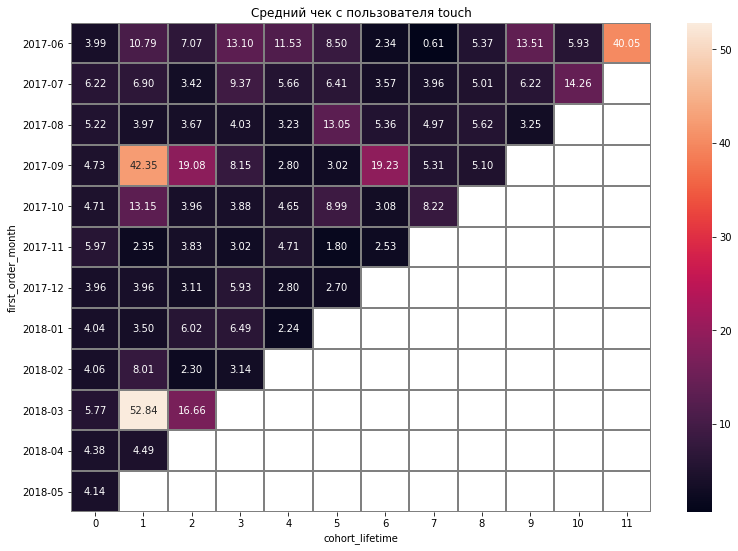

In [33]:
def mean_check(df):
    for device in ['desktop', 'touch']:
        df_final = df.query('device == @device')
        orders_grouped_by_cohorts = df_final.groupby(['first_order_month','order_month']).\
                                                agg({'revenue':'sum','uid':'nunique'})
        orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']

        orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
        orders_grouped_by_cohorts['order_month'] = orders_grouped_by_cohorts['order_month'].astype('datetime64[M]')
        orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].astype('datetime64[M]')
        orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']
        orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
        orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
        orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')
        orders_grouped_by_cohorts = orders_grouped_by_cohorts.query('first_order_month < "2018-06"')
        revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',
                                                                       columns='cohort_lifetime',
                                                                       values='revenue_per_user',
                                                                       aggfunc='mean')
        plt.figure(figsize=(13, 9))
        plt.title('Средний чек с пользователя {:}'.format(device))
        sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
        revenue_per_user = orders_grouped_by_cohorts['revenue'].sum()/orders_grouped_by_cohorts['uid'].sum()
        print('{:}'.format(device))
        print('Средний чек с пользователя: {:.2f}'.format(revenue_per_user))
        print('')
mean_check(orders_log)

### Вывод 

Средний чек с пользователя –– 6.14 у.е. В когортных таблицах можно увидеть, что в некоторых когортах эти данные существенно отличаются от средних значений. Это может быть в результате каких-то сезонных событий(значимый концерт супер-известной звезды, на который собираются все, например).

### 2.8 Сколько денег приносят? (LTV) <a id="step28"></a>

In [34]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

In [35]:
orders_log['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

Суммарный доход: 252057.2


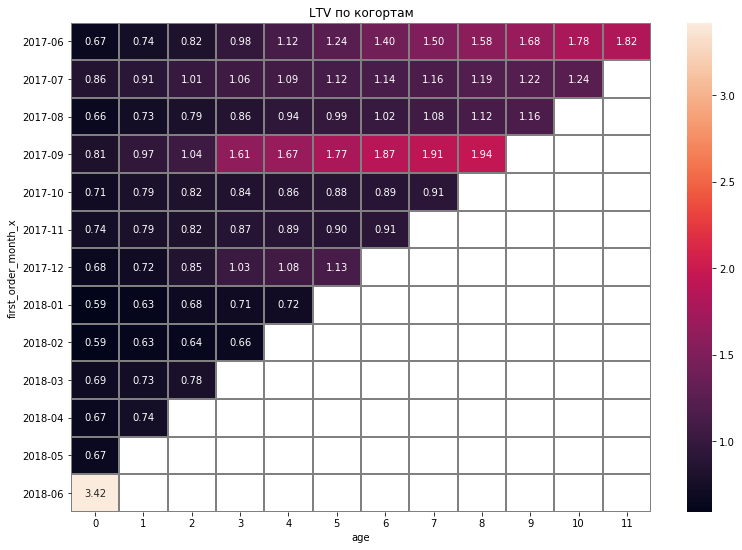

In [47]:
costs['month'] = costs['dt'].astype('datetime64[M]')
orders_log_groupped = orders_log.groupby('uid')['buy_ts'].min()
visits_log_groupped = visits_log.groupby('uid')['start_ts'].min()
first_orders = orders_log.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month_x']
cohort_sizes = first_orders.groupby('first_order_month_x').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month_x', 'n_buyers']
orders_new = pd.merge(orders_log,first_orders, on='uid')

cohorts = orders_new.groupby(['first_order_month_x','order_month','source_id']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_order_month_x')

margin_rate = 1
    
report['gp'] = report['revenue'] * margin_rate
report['order_month'] = report['order_month'].astype('datetime64[M]')
report['first_order_month_x'] = report['first_order_month_x'].astype('datetime64[M]')
report['age'] = report['order_month'] - report['first_order_month_x']
report['age'] = report['age'] / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['first_order_month_x'] = report['first_order_month_x'].dt.strftime('%Y-%m')
report['ltv'] = report['gp'] / report['n_buyers']


output = report.pivot_table(
        index='first_order_month_x', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').\
        cumsum(axis=1)
    
output.fillna('')

plt.figure(figsize=(13, 9))
plt.title('LTV по когортам')
sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

print('Суммарный доход:',report['revenue'].sum())

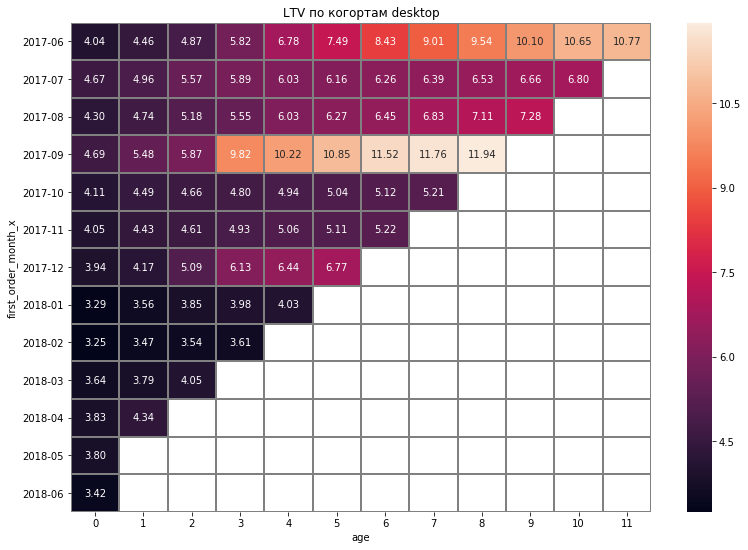

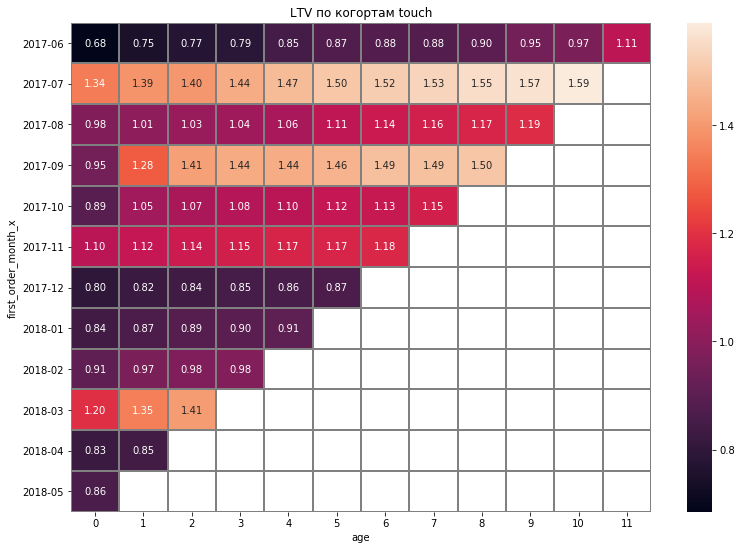

In [48]:
def ltv_by_device(df):
    for device in ['desktop', 'touch']:
        df_final = df.query('device == @device')
        cohorts = df_final.groupby(['first_order_month_x','order_month','device']).agg({'revenue': 'sum'}).reset_index()
        report = pd.merge(cohort_sizes, cohorts, on='first_order_month_x')

        margin_rate = 1

        report['gp'] = report['revenue'] * margin_rate
        report['order_month'] = report['order_month'].astype('datetime64[M]')
        report['first_order_month_x'] = report['first_order_month_x'].astype('datetime64[M]')
        report['age'] = report['order_month'] - report['first_order_month_x']
        report['age'] = report['age'] / np.timedelta64(1, 'M')
        report['age'] = report['age'].round().astype('int')

        report['first_order_month_x'] = report['first_order_month_x'].dt.strftime('%Y-%m')
        report['ltv'] = report['gp'] / report['n_buyers']

        output = report.pivot_table(
                index='first_order_month_x', 
                columns='age', 
                values='ltv', 
                aggfunc='mean').\
                cumsum(axis=1)

        output.fillna('')

        plt.figure(figsize=(13, 9))
        plt.title('LTV по когортам {:}'.format(device))
        sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
ltv_by_device(orders_new)

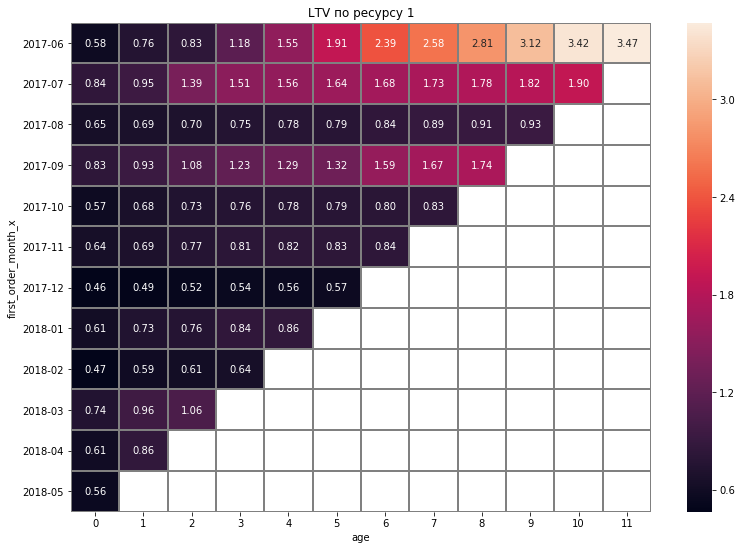

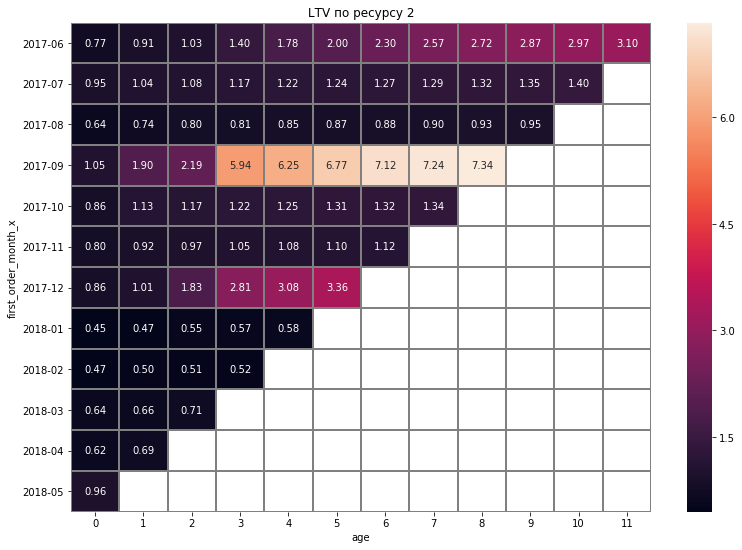

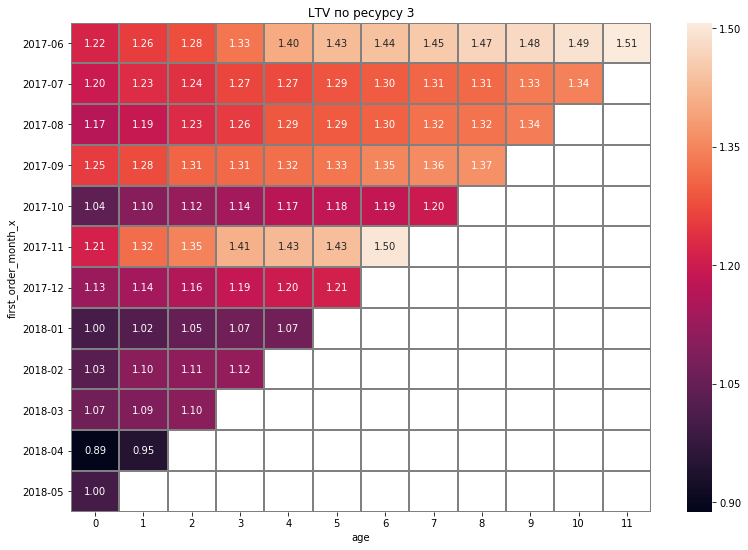

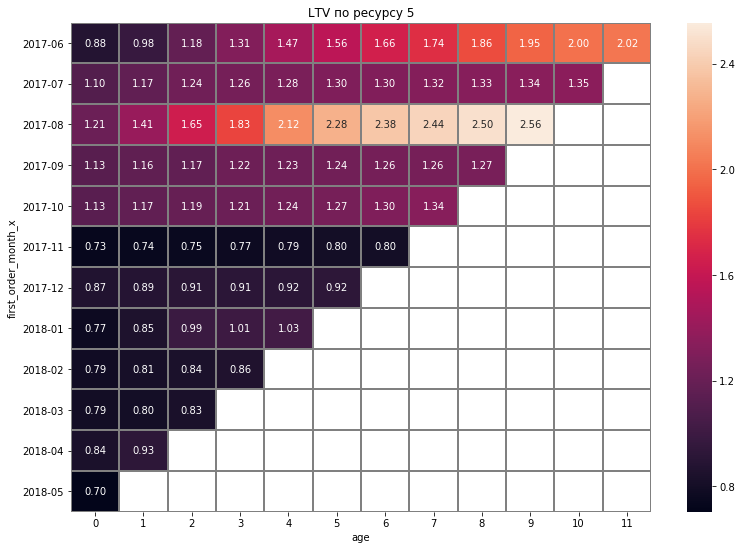

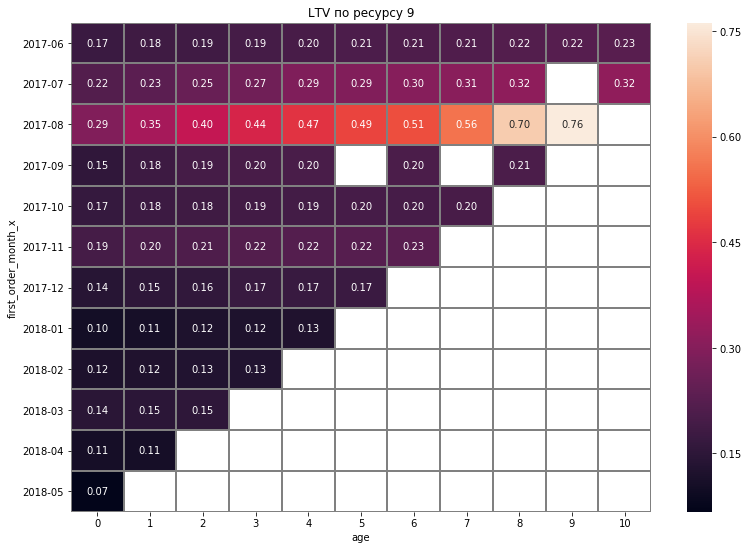

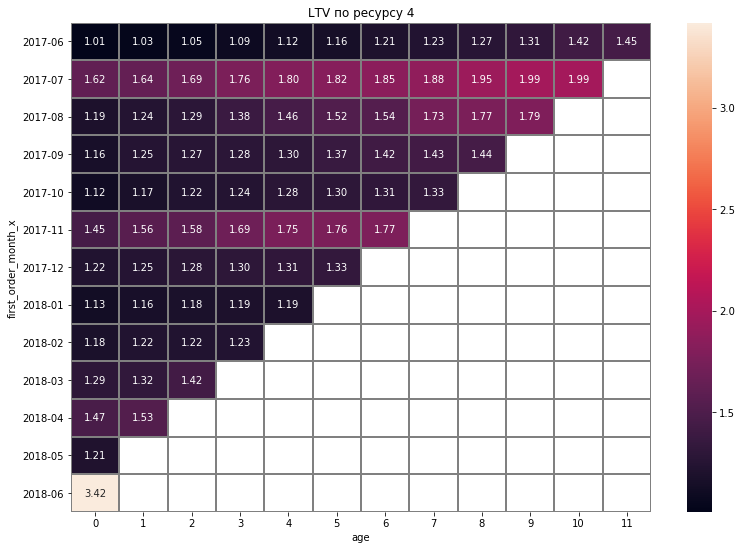

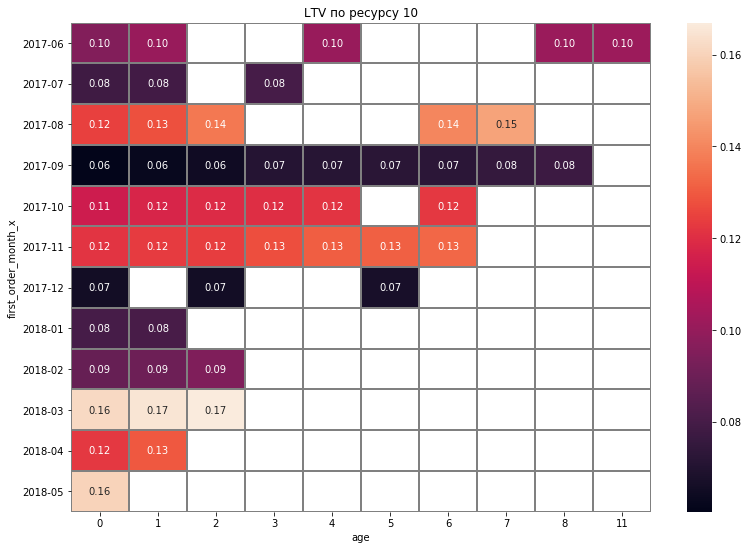

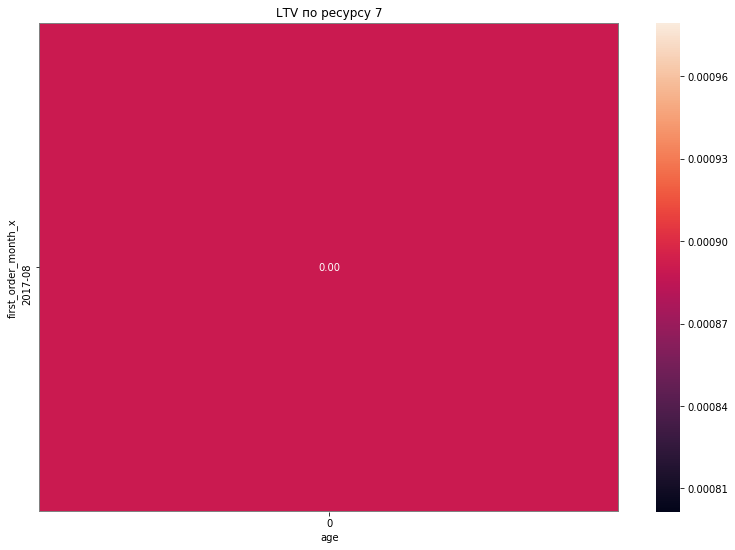

In [49]:
def ltv_by_source_id(df):
    for source_id in orders_new.source_id.unique():
        df_final = df.query('source_id == @source_id')
        cohorts = df_final.groupby(['first_order_month_x','order_month','source_id']).agg({'revenue': 'sum'}).reset_index()
        report = pd.merge(cohort_sizes, cohorts, on='first_order_month_x')

        margin_rate = 1

        report['gp'] = report['revenue'] * margin_rate
        report['order_month'] = report['order_month'].astype('datetime64[M]')
        report['first_order_month_x'] = report['first_order_month_x'].astype('datetime64[M]')
        report['age'] = report['order_month'] - report['first_order_month_x']
        report['age'] = report['age'] / np.timedelta64(1, 'M')
        report['age'] = report['age'].round().astype('int')

        report['first_order_month_x'] = report['first_order_month_x'].dt.strftime('%Y-%m')
        report['ltv'] = report['gp'] / report['n_buyers']
        output = report.pivot_table(
                index='first_order_month_x', 
                columns='age', 
                values='ltv', 
                aggfunc='mean').\
                cumsum(axis=1)

        output.fillna('')

        plt.figure(figsize=(13, 9))
        plt.title('LTV по ресурсу {:}'.format(source_id))
        sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

ltv_by_source_id(orders_new)



### Вывод

Изучив данные мы видим, что основной вклад в LTV вносит первая когорта, то есть больше всего пользователи тратят денег именно в первый месяц использования. Для десктопа этот показатель существенно выше. По ресурсам наиболее ценные клиенты приходят из ресурсов 4,3, неплохие клиенты из ресурсов 2 и 5. Наименее ценные из ресурсов 9 и 10. Следует оценить данные с учётом стоимости привлечения данных клиентов.

### 2.9 Сколько денег потратили? Всего / на каждый источник / по времени <a id="step29"></a>

In [39]:
report

,first_order_month_x,n_buyers,order_month,source_id,revenue,gp,age,ltv
0,2017-06,2023,2017-06-01,1,1168.450,584.225,0,0.289
1,2017-06,2023,2017-06-01,2,1551.760,775.880,0,0.384
2,2017-06,2023,2017-06-01,3,2466.710,1233.355,0,0.610
3,2017-06,2023,2017-06-01,4,2039.640,1019.820,0,0.504
4,2017-06,2023,2017-06-01,5,1787.680,893.840,0,0.442
...,...,...,...,...,...,...,...,...
510,2018-05,2988,2018-05-01,4,3616.230,1808.115,0,0.605
511,2018-05,2988,2018-05-01,5,2103.240,1051.620,0,0.352
512,2018-05,2988,2018-05-01,9,200.380,100.190,0,0.034
513,2018-05,2988,2018-05-01,10,478.930,239.465,0,0.080


,costs
source_id,
3,141321.630
4,61073.600
5,51757.100
2,42806.040
1,20833.270
10,5822.490
9,5517.490


Text(0, 0.5, 'Суммарные расходы')

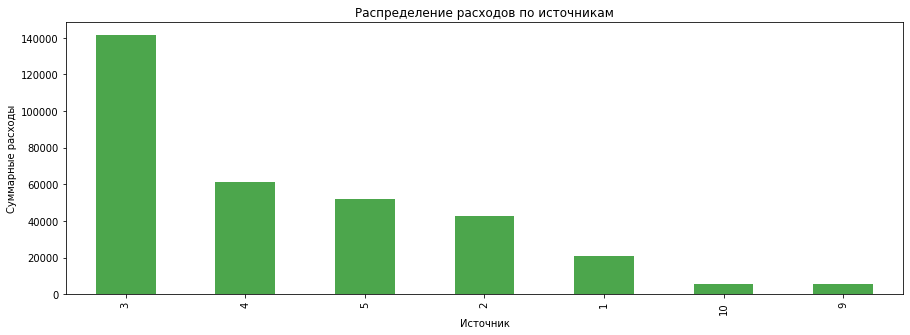

In [40]:
monthly_costs_by_source = costs.groupby(['source_id']).\
                         agg({'costs':'sum'}).\
                        sort_values('costs',ascending=False)
display(monthly_costs_by_source)

plt.figure(figsize=(10, 5))
plt.title('Распределение расходов по источникам')
monthly_costs_by_source['costs'].plot(kind='bar',
                                     color='g', 
                              alpha=0.7, 
                              linewidth=2, 
                              figsize=(15,5))
plt.xlabel('Источник')
plt.ylabel('Суммарные расходы')

In [41]:
monthly_costs_new = costs.groupby(['month','source_id']).\
                         agg({'costs':'sum'}).\
                         reset_index()
display(monthly_costs_new.head(5))
print('Всего маркетинговых расходов: {:.0f}'.format(monthly_costs_new['costs'].sum()))

,month,source_id,costs
0,2017-06-01,1,1125.610
1,2017-06-01,2,2427.380
2,2017-06-01,3,7731.650
3,2017-06-01,4,3514.800
4,2017-06-01,5,2616.120


Всего маркетинговых расходов: 329132


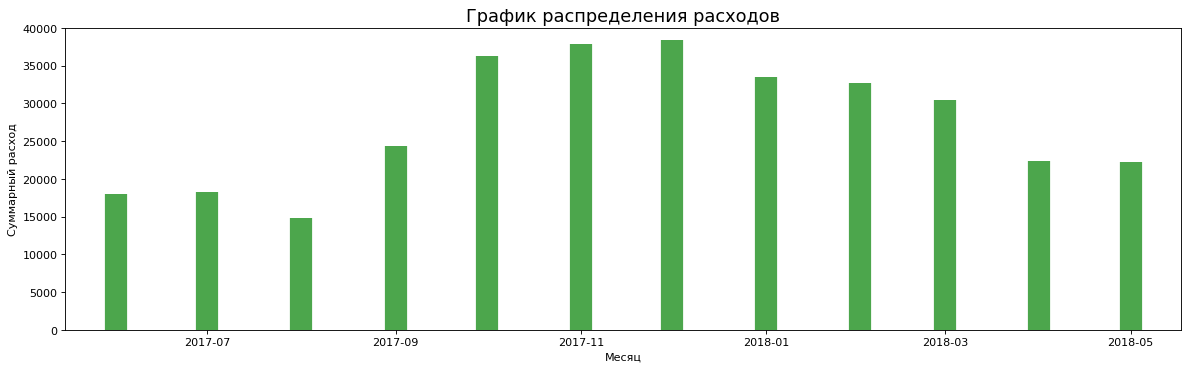

In [42]:
# Создаём датафрейм с сортировкой на количеству рейсов
df_model_sorted = costs.groupby(['month']).sum()

# Создаём функцию для постоения столбчатой диаграммы по заданным параметрам 
def bar_plot(df,col1,col2,v):
    # Определяем фигуру и поле, создаём сабплот
    fig, ax = plt.subplots(figsize=(18,5), facecolor='white', dpi= 80)
    ax.vlines(x=df.index, ymin=0, ymax=df[col2], color='g', alpha=0.7, linewidth=20)

    # Задаём название графика и осей
    ax.set_title('График распределения расходов', fontdict={'size':16})
    ax.set(ylabel='Суммарный расход', ylim=(0,40000)) 
    ax.set(xlabel='Месяц') 
    plt.show() 
# Применяем функцию    
df_model_sorted.pipe(bar_plot,'month','costs',10.5)

### Вывод

Больше всего расходов приходиться на 3-ий и 4-ый ресурс. Вероятно, аналитики уже изучили данные, что LTV этих ресурсов лучше остальных. Распределения расходов по месяцам напоминает график MAU, значит ощутимая доля трафика пришла от продвижения. Суммарное количество расходов 329 132 у.е. Доход при этом 252 057. Это может означать, что сервис находится в активной стадии роста, вкладывается в маркетинг, текущие вложение могут окупиться при дальнейшем использовании пользователями ресурса.

### 2.10 Сколько стоило привлечение одного покупателя из каждого источника? <a id="step210"></a>

,first_order_month_x,n_buyers,order_month,source_id_x,revenue,gp,age,ltv,month,source_id_y,costs,cac
0,2017-06-01,2023,2017-06-01,1,1168.450,584.225,0,0.289,2017-06-01,1,1125.610,0.556
1,2017-06-01,2023,2017-06-01,1,1168.450,584.225,0,0.289,2017-06-01,2,2427.380,1.200
2,2017-06-01,2023,2017-06-01,1,1168.450,584.225,0,0.289,2017-06-01,3,7731.650,3.822
3,2017-06-01,2023,2017-06-01,1,1168.450,584.225,0,0.289,2017-06-01,4,3514.800,1.737
4,2017-06-01,2023,2017-06-01,1,1168.450,584.225,0,0.289,2017-06-01,5,2616.120,1.293


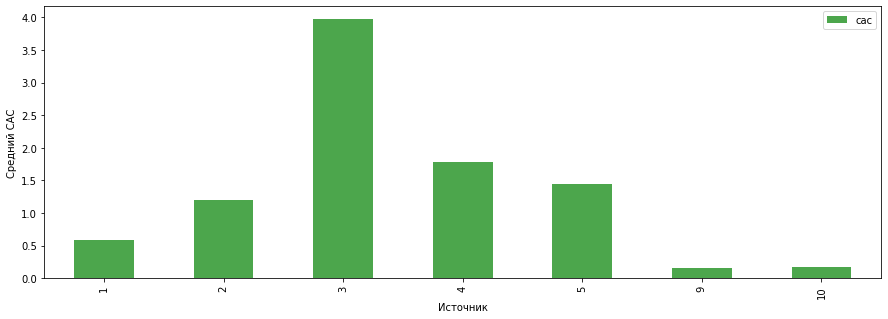

In [43]:
report['first_order_month_x'] = pd.to_datetime(report['first_order_month_x'])
report_new = pd.merge(report, monthly_costs_new, left_on='first_order_month_x', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.groupby('source_id_y').\
          agg({'cac':'mean'}).\
          plot(kind='bar',
              color='g', 
               alpha=0.7, 
               linewidth=2, 
               figsize=(15,5))
plt.xlabel('Источник')
plt.ylabel('Средний CAC')
              
report_new.head()

### Вывод


Видим, что для ресурсов 3 и 4 также самая высокая стоимость привлечения пользователя. Это может быть связано с тем, что по ним больше всего затрат, со временем для любого ресурса целевая аудитория может быть охвачена и новый пользователь станет дороже. 
Ресуры 9 и 10 приводят самых дешёвых пользователей.

### 2.11 На сколько окупились расходы? (ROMI) <a id="step211"></a>


In [44]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
report_new['first_order_month_x'] = report_new['first_order_month_x'].astype('datetime64[M]').dt.strftime('%Y-%m')
report_new.info(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3598 entries, 0 to 3597
Data columns (total 13 columns):
first_order_month_x    3598 non-null object
n_buyers               3598 non-null int64
order_month            3598 non-null datetime64[ns]
source_id_x            3598 non-null int64
revenue                3598 non-null float64
gp                     3598 non-null float64
age                    3598 non-null int64
ltv                    3598 non-null float64
month                  3598 non-null datetime64[ns]
source_id_y            3598 non-null int64
costs                  3598 non-null float64
cac                    3598 non-null float64
romi                   3598 non-null float64
dtypes: datetime64[ns](2), float64(6), int64(4), object(1)
memory usage: 393.5+ KB


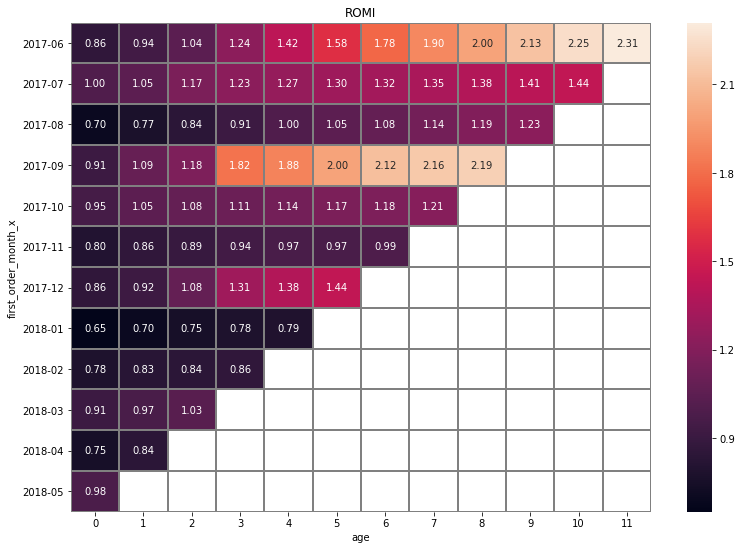

In [45]:
output_new = report_new.pivot_table(
        index='first_order_month_x', 
        columns='age', 
        values='romi', 
        aggfunc='mean')
output_new.fillna('')
output_new= output_new.cumsum(axis=1).round(2)
plt.figure(figsize=(13, 9))
plt.title('ROMI')
sns.heatmap(output_new, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

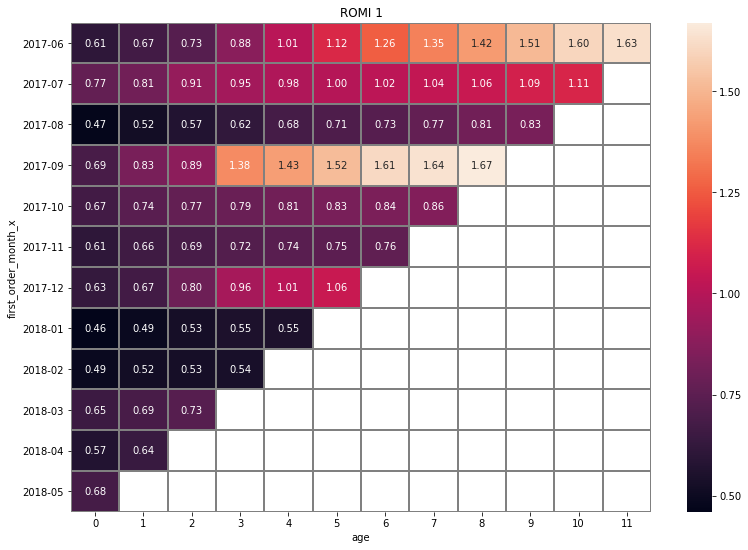

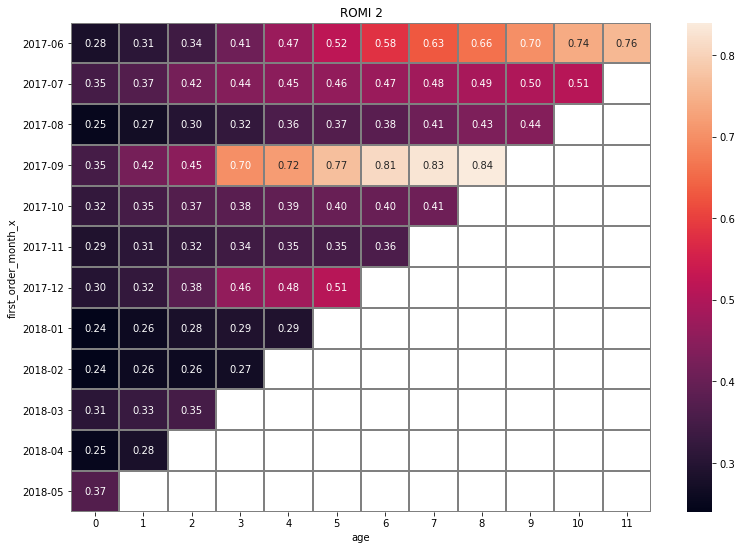

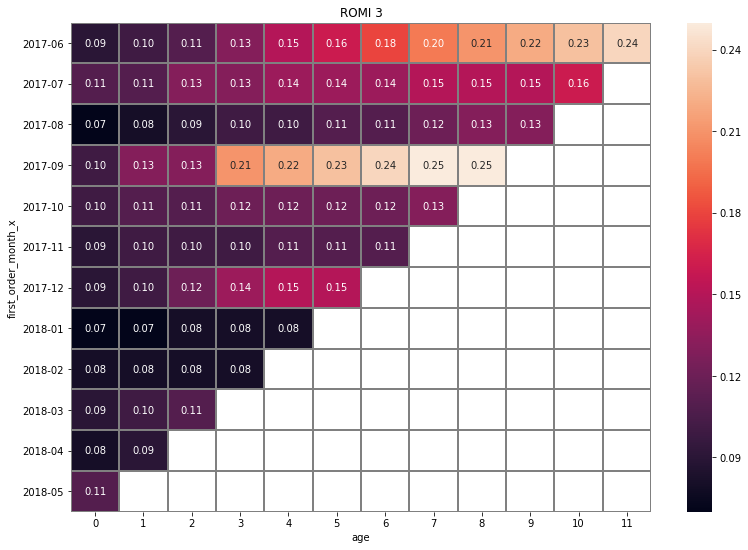

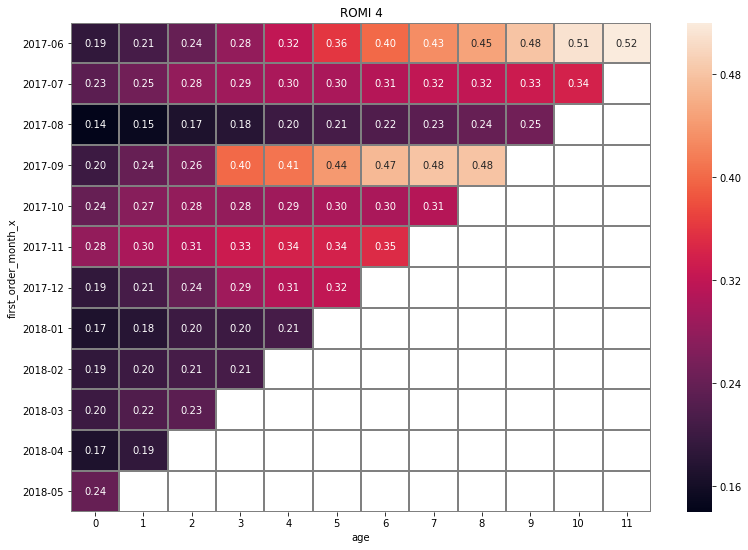

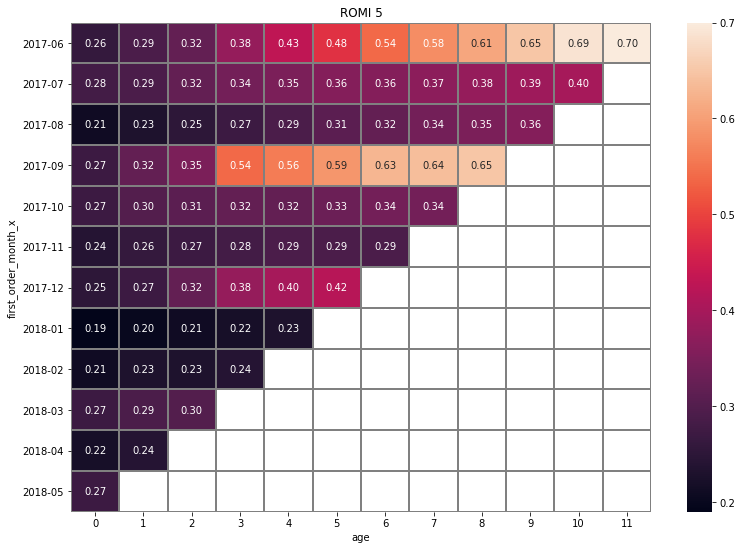

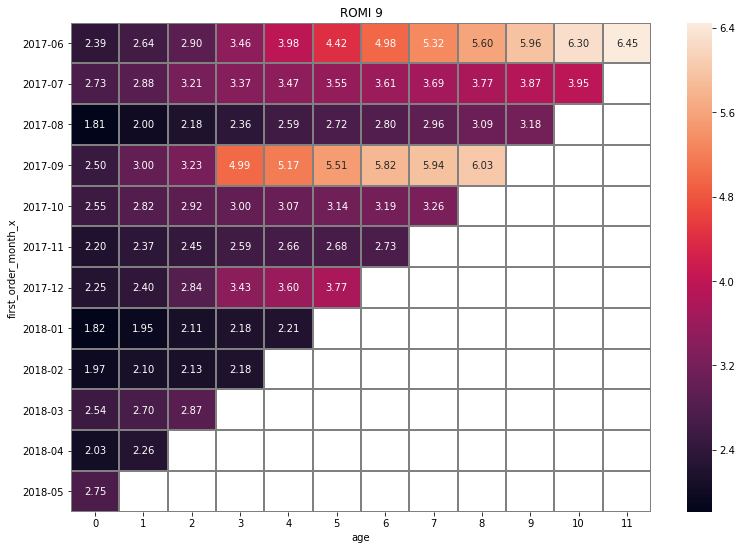

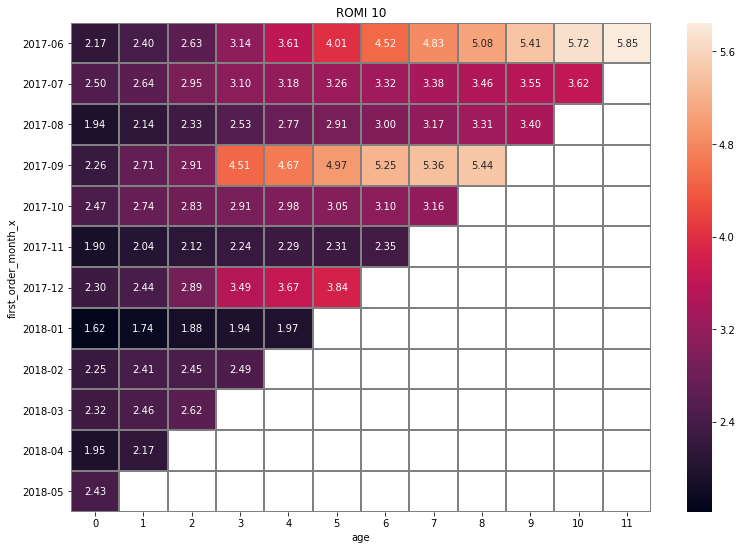

In [46]:
def romi_by_source_id(df):
    for source_id_y in report_new.source_id_y.unique():
        df_final = df.query('source_id_y == @source_id_y')

        output_new = df_final.pivot_table(
                index='first_order_month_x', 
                columns='age', 
                values='romi', 
                aggfunc='mean')
        output_new.fillna('')
        output_new= output_new.cumsum(axis=1).round(2)
        plt.figure(figsize=(13, 9))
        plt.title('ROMI {:}'.format(source_id_y))
        sns.heatmap(output_new, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
romi_by_source_id(report_new)        

## 3. Вывод и рекомендации <a id="step3"></a>

Мы видим, что инвестиции в рекламу окупаются на 2-3 месяц в среднем. В некоторых когортах видим заметное увеличение окупаемости к концу периода. В качестве новых источников рекомендую рассмотреть источник 1, 9 и 10. Они показывают хорошие показатели окупаемости маркетинговых инвестиции, за последний период на них продвигались меньше всего, а значит это может быть хорошим источником свежей аудитории. От источников 3-4 можно смело отказываться, либо рассмотреть другой подход к продвижению на них. Аналогичная ситуация с источниками 2 и 5. Даже спустя год инвестиции не окупились, это не очень хороший показатель. Следует продумать над продвижением на них другим способом, либо также сделать упор в более выгодные источники. По платформам не предлагаю делать упор на десктоп, хоть он и более прибыльный, поскольку большая часть пользователей в интернете сейчас сидят с мобильных устройств, будет неправильно исключить таких людей, однако бОльший упор в десктоп всё же стоит учесть. 